This code: merges CSV files, shows which days and hours are in the collective database, creates df, converts x, y, values in to date-time and price including VAT and energy tax 2025 (0.1228). it should prompt for energy tax values, allowing to enter future tax values.

it shows the development of price predictions for the period -4 hours till 7 x 24 hours in the future.


In [24]:
# combine all prediction files into a single database
import os
import pandas as pd
import glob
from pathlib import Path
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the folder containing the CSV files
folder_path = Path("oxygent_data")

# Get all CSV files in the folder
csv_files = list(folder_path.glob("*.csv")) + list(folder_path.glob("*.CSV"))

# Sort files based on timestamp in filename
csv_files.sort(key=lambda x: x.stem.split("_")[-1].replace(":", ""))

# Read and concatenate all CSV files
df_list = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        df_list.append(df)
        logging.info(f"Successfully read {file}")
    except Exception as e:
        logging.error(f"Error reading {file}: {e}")

if df_list:
    merged_df = pd.concat(df_list, ignore_index=True)

    # Save the merged data
    output_file = "merged_data_price_preds.csv"
    merged_df.to_csv(output_file, index=False)
    logging.info(f"Merged {len(csv_files)} files into '{output_file}'")
else:
    logging.warning("No files were read successfully.")

2025-03-25 20:27:39,338 - INFO - Successfully read oxygent_data/merged_data_price_preds_upto25Mar.csv
2025-03-25 20:27:40,175 - INFO - Merged 1 files into 'merged_data_price_preds.csv'


In [3]:
# Generate descriptive statistics for the merged data
descriptive_stats = merged_df.describe()

# Print the descriptive statistics
print(descriptive_stats)
print(merged_df)

                  x              y       subarray
count  6.834860e+05  683486.000000  683486.000000
mean   1.741857e+07       0.101359       2.855786
std    7.237140e+03       0.062454       1.521744
min    1.740352e+07      -0.213000       0.000000
25%    1.741270e+07       0.066000       2.000000
50%    1.741871e+07       0.106000       3.000000
75%    1.742425e+07       0.141000       4.000000
max    1.743534e+07       0.365000       5.000000
                 x        y                         timestamp  subarray
0       17403516.0  0.01000  2025-02-25T00:04:11.929962+00:00         0
1       17403552.0  0.01189  2025-02-25T00:04:11.929962+00:00         0
2       17403588.0  0.01243  2025-02-25T00:04:11.929962+00:00         0
3       17403624.0  0.00768  2025-02-25T00:04:11.929962+00:00         0
4       17403660.0  0.00393  2025-02-25T00:04:11.929962+00:00         0
...            ...      ...                               ...       ...
683481  17435196.0  0.10000  2025-03-25T19:00:

In [25]:
# prepare for pivot table to visualize extend of database

# Extract dates from the 'timestamp' column
merged_df['date_timestamp'] = pd.to_datetime(merged_df['timestamp']).dt.date
# Extract hour from the 'timestamp' column
merged_df['hour_timestamp'] = pd.to_datetime(merged_df['timestamp']).dt.hour

# Create a pivot table to show unique combinations of hour_timestamp and date_timestamp
pivot_table = merged_df.pivot_table(index='hour_timestamp', columns='date_timestamp', values='timestamp', aggfunc='nunique', fill_value=0)

# Convert column index to datetime and extract the day
pivot_table.columns = pd.to_datetime(pivot_table.columns).day

# Print df headers
print(merged_df)



                 x        y                         timestamp  subarray  \
0       17403516.0  0.01000  2025-02-25T00:04:11.929962+00:00         0   
1       17403552.0  0.01189  2025-02-25T00:04:11.929962+00:00         0   
2       17403588.0  0.01243  2025-02-25T00:04:11.929962+00:00         0   
3       17403624.0  0.00768  2025-02-25T00:04:11.929962+00:00         0   
4       17403660.0  0.00393  2025-02-25T00:04:11.929962+00:00         0   
...            ...      ...                               ...       ...   
683481  17435196.0  0.10000  2025-03-25T19:00:04.963399+00:00         5   
683482  17435232.0  0.11000  2025-03-25T19:00:04.963399+00:00         5   
683483  17435268.0  0.11700  2025-03-25T19:00:04.963399+00:00         5   
683484  17435304.0  0.10400  2025-03-25T19:00:04.963399+00:00         5   
683485  17435340.0  0.09000  2025-03-25T19:00:04.963399+00:00         5   

       date_timestamp  hour_timestamp  
0          2025-02-25               0  
1          2025-02-

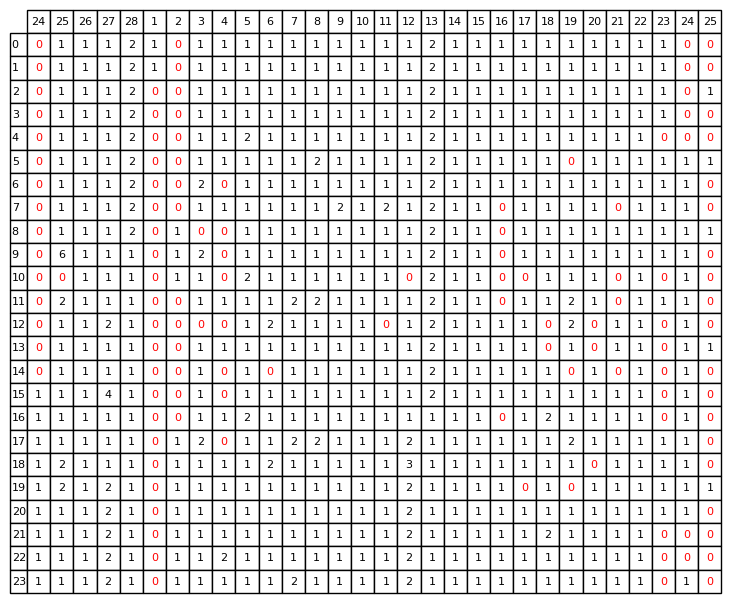

In [26]:
# Print the pivot table with grids and highlight count values of '0' in red font
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=pivot_table.values, colLabels=pivot_table.columns, rowLabels=pivot_table.index, cellLoc='center', loc='center')

# Apply styles to the table
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('black')
    if i > 0 and j > -1 and pivot_table.iat[i-1, j] == 0:
        cell.set_text_props(color='red')


table.auto_set_font_size(True)
table.set_fontsize(8)
table.scale(1.4, 1.4)



plt.show()

In [27]:
# ensure conversion from net price to price including taxes..

from datetime import datetime

# Make sure the datetime column exists so we can determine the years
if 'date_time' not in merged_df.columns:
    merged_df['date_time'] = merged_df['x'].apply(lambda x: datetime.fromtimestamp(x * 100000 / 1000))

# Build a mapping of year to energy tax rate
years = merged_df['date_time'].dt.year.unique()
energy_tax_rates = {}
for year in sorted(years):
    if year == 2025:
        energy_tax_rates[year] = 0.1228
    else:
        rate_input = input(f"Enter energy tax rate for year {year}: ")
        try:
            energy_tax_rates[year] = float(rate_input)
        except Exception as e:
            print(f"Invalid input, defaulting energy tax rate for {year} to 0.0")
            energy_tax_rates[year] = 0.0

print("Energy tax rates by year:", energy_tax_rates)


Energy tax rates by year: {np.int32(2025): 0.1228}


In [28]:
merged_df['Price'] = merged_df['y'] * 1.21 + energy_tax_rates[2025]


In [29]:
# Sort merged_df based on the proper datetime column to avoid plotting errors
merged_df = merged_df.sort_values(by=['date_timestamp', 'hour_timestamp', 'date_time'])

print("Sorted head values:")
print(merged_df.head(2))
print()
print("Sorted tail values:")
print(merged_df.tail(2))

Sorted head values:
                x      y                         timestamp  subarray  \
80746  17403516.0  0.010  2025-02-24T15:40:49.845469+00:00         0   
80795  17403516.0  0.152  2025-02-24T15:40:49.845469+00:00         1   

      date_timestamp  hour_timestamp  date_time    Price  
80746     2025-02-24              15 2025-02-24  0.13490  
80795     2025-02-24              15 2025-02-24  0.30672  

Sorted tail values:
                 x     y                         timestamp  subarray  \
683296  17435340.0  0.12  2025-03-25T19:00:04.963399+00:00         4   
683485  17435340.0  0.09  2025-03-25T19:00:04.963399+00:00         5   

       date_timestamp  hour_timestamp           date_time   Price  
683296     2025-03-25              19 2025-04-01 21:00:00  0.2680  
683485     2025-03-25              19 2025-04-01 21:00:00  0.2317  


In [30]:
point_est_price_df = merged_df[merged_df['subarray'] == 1]

In [31]:

# Print the head and tail rows of point_est_price_df
print("head values")
print(point_est_price_df.head(2))
print()
print("tail values")
print(point_est_price_df.tail(2))

head values
                x      y                         timestamp  subarray  \
80795  17403516.0  0.152  2025-02-24T15:40:49.845469+00:00         1   
80796  17403552.0  0.145  2025-02-24T15:40:49.845469+00:00         1   

      date_timestamp  hour_timestamp           date_time    Price  
80795     2025-02-24              15 2025-02-24 00:00:00  0.30672  
80796     2025-02-24              15 2025-02-24 01:00:00  0.29825  

tail values
                 x      y                         timestamp  subarray  \
682728  17435304.0  0.125  2025-03-25T19:00:04.963399+00:00         1   
682729  17435340.0  0.110  2025-03-25T19:00:04.963399+00:00         1   

       date_timestamp  hour_timestamp           date_time    Price  
682728     2025-03-25              19 2025-04-01 20:00:00  0.27405  
682729     2025-03-25              19 2025-04-01 21:00:00  0.25590  


// Price values match price shown on energie.theoxigent.nl, re-confirmed by checking price values most into the future. Based on CSV file 'oxygent_data/time_series_data_20250317 12:45.csv' //


In [32]:
import datetime

# Define the time range
start_time = datetime.datetime.now() - datetime.timedelta(hours=4)
end_time = datetime.datetime.now() + datetime.timedelta(days=7)

# Filter the DataFrame based on the time range
filtered_df = point_est_price_df[(point_est_price_df['date_time'] >= start_time) & (point_est_price_df['date_time'] <= end_time)]

# Further filter the DataFrame to only include hour_timestamp values equal to 1, 7, 13, or 19
filtered_df = filtered_df[(filtered_df['hour_timestamp'] == 1) | 
                          (filtered_df['hour_timestamp'] == 7) | 
                          (filtered_df['hour_timestamp'] == 13) | 
                          (filtered_df['hour_timestamp'] == 19)]

/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_1823/3755664397.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Blues", n_groups)


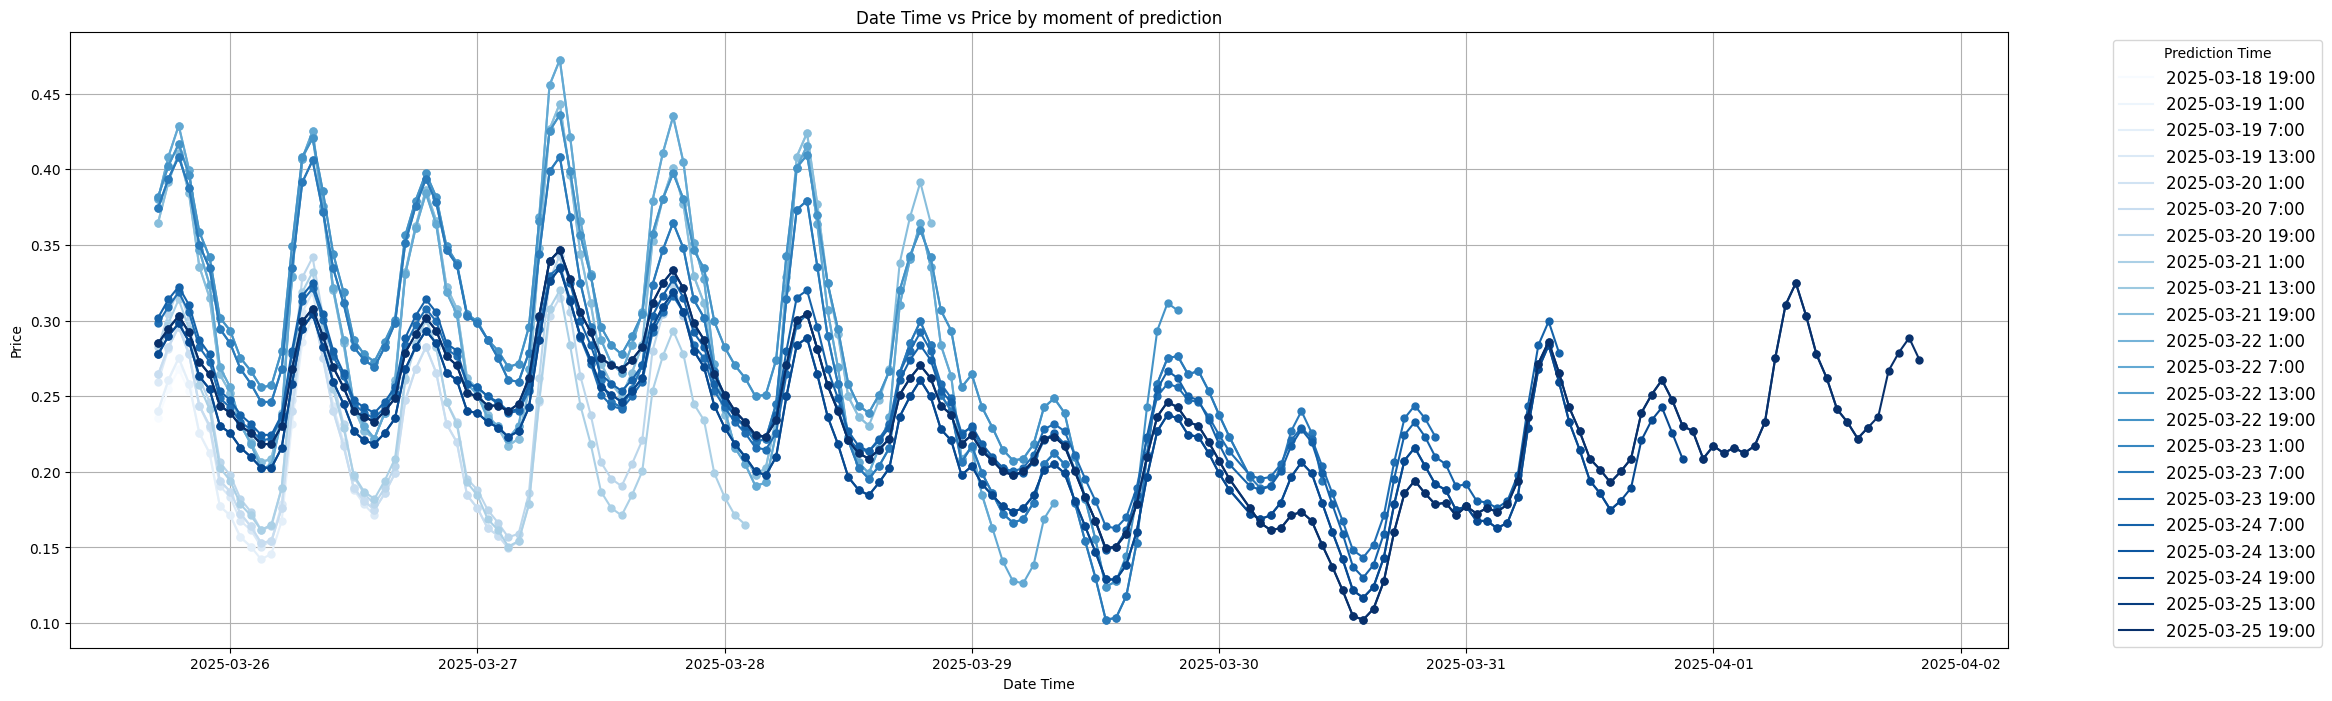

In [33]:
import matplotlib.cm as cm

# Group the filtered data by date_timestamp and hour_timestamp
unique_combinations = filtered_df.groupby(['date_timestamp', 'hour_timestamp'])
n_groups = len(unique_combinations)
cmap = cm.get_cmap("Blues", n_groups)

plt.figure(figsize=(25, 8))  # Adjust the figure size

line_handles = []  # to store line objects
labels = []
for i, ((date_timestamp, hour_timestamp), group) in enumerate(unique_combinations):
    color = plt.get_cmap("Blues", n_groups)(i)
    line, = plt.plot(group['date_time'], group['Price'], color=color,
                     marker='o', markersize=5, linestyle='-', 
                     label=f'{date_timestamp} {hour_timestamp}:00')
    line_handles.append(line)
    labels.append(f'{date_timestamp} {hour_timestamp}:00')

# Create custom legend handles showing only the line (color)
legend_handles = [
    plt.Line2D([], [], color=line.get_color(), linestyle=line.get_linestyle(), linewidth=line.get_linewidth())
    for line in line_handles
]

plt.xlabel('Date Time')
plt.ylabel('Price')
plt.title('Date Time vs Price by moment of prediction')
plt.ylim()  # Set no y-axis limits, alternatively: (0.0, 0.5) or similar
plt.legend(legend_handles, labels, title='Prediction Time', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True)
plt.show()
